# Act 2: The Signal

## From Raw Lab Values to Predictive Features

> "The difference between a healthy person and someone with lupus isn't always obvious in a single lab value. It's in the *pattern* — the combination of elevated markers, the deviation from *their* baseline, the persistence over time."

---

### Key Findings

1. **Raw values are noisy**: CRP of 8 mg/L means different things for a 20-year-old vs a 70-year-old
2. **Z-scores normalize age/sex effects**: Deviation from healthy baseline is more informative
3. **Engineered features amplify signal**: Inflammatory burden, anemia patterns, multi-marker combinations
4. **Missingness is a feature**: What tests were NOT ordered is clinically meaningful
5. **Top predictive features**: ESR z-score, CRP z-score, inflammatory burden, and age

---

In [1]:
import sys
from pathlib import Path

src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from visualization.style import apply_aura_style, PALETTE, C, CATEGORY_COLOR, CAT_COLORS
from visualization.style import AURA_DIVERGING, AURA_SEQUENTIAL, AURA_TEAL, AURA_RDYLGN
apply_aura_style()

Path('../outputs/figures').mkdir(parents=True, exist_ok=True)

# ── Label helpers ──────────────────────────────────────────────────────────────
LAB_LABELS = {
    'wbc': 'WBC', 'rbc': 'RBC', 'hemoglobin': 'Hemoglobin',
    'hematocrit': 'Hematocrit', 'platelet_count': 'Platelet Count',
    'mcv': 'MCV', 'mch': 'MCH', 'rdw': 'RDW', 'esr': 'ESR', 'crp': 'CRP',
    'crp_zscore': 'CRP Z-Score', 'wbc_zscore': 'WBC Z-Score',
    'rbc_zscore': 'RBC Z-Score', 'hemoglobin_zscore': 'Hemoglobin Z-Score',
    'inflammatory_burden': 'Inflammatory Burden',
    'high_inflammation': 'High Inflammation',
}
CLUSTER_LABELS = {
    'healthy': 'Healthy', 'systemic': 'Systemic',
    'gastrointestinal': 'Gastrointestinal', 'endocrine': 'Endocrine',
}

def clean_label(s):
    s = str(s)
    if s in CLUSTER_LABELS:
        return CLUSTER_LABELS[s]
    if s in LAB_LABELS:
        return LAB_LABELS[s]
    return s.replace('_', ' ').title()

priority = ['healthy', 'systemic', 'gastrointestinal', 'endocrine']
cluster_colors = [CATEGORY_COLOR.get(c, C['muted']) for c in priority]

BOXPLOT_PROPS = dict(
    patch_artist=True,
    flierprops=dict(marker='o', markerfacecolor=C['text'], markeredgecolor=C['border'],
                    markersize=3, linestyle='none', alpha=0.55),
    medianprops=dict(color=C['accent'], linewidth=2.0),
    whiskerprops=dict(color=C['muted'], linewidth=1.2),
    capprops=dict(color=C['muted'], linewidth=1.2),
    boxprops=dict(linewidth=1.2),
)

print('Setup complete!')

Setup complete!


In [2]:
from data.loaders import load_modeling_data
from data.preprocessing import preprocess_for_modeling

df_raw = load_modeling_data()
df = preprocess_for_modeling(df_raw, priority_only=True)

print(f'Loaded {len(df):,} patients (priority clusters only)')
print(f'Raw features: {len(df.columns)}')
print(f'\nCluster distribution:')
print(df['diagnosis_cluster'].value_counts())

Loaded 48,503 patients (priority clusters only)
Raw features: 54

Cluster distribution:
diagnosis_cluster
healthy             32706
systemic            13030
endocrine            1966
gastrointestinal      801
Name: count, dtype: int64


## 1. Why Raw Lab Values Fall Short

A CRP of 15 mg/L sounds elevated — but is it? Without context, it's just a number. Lab reference ranges ignore age and sex. Z-scores fix this.

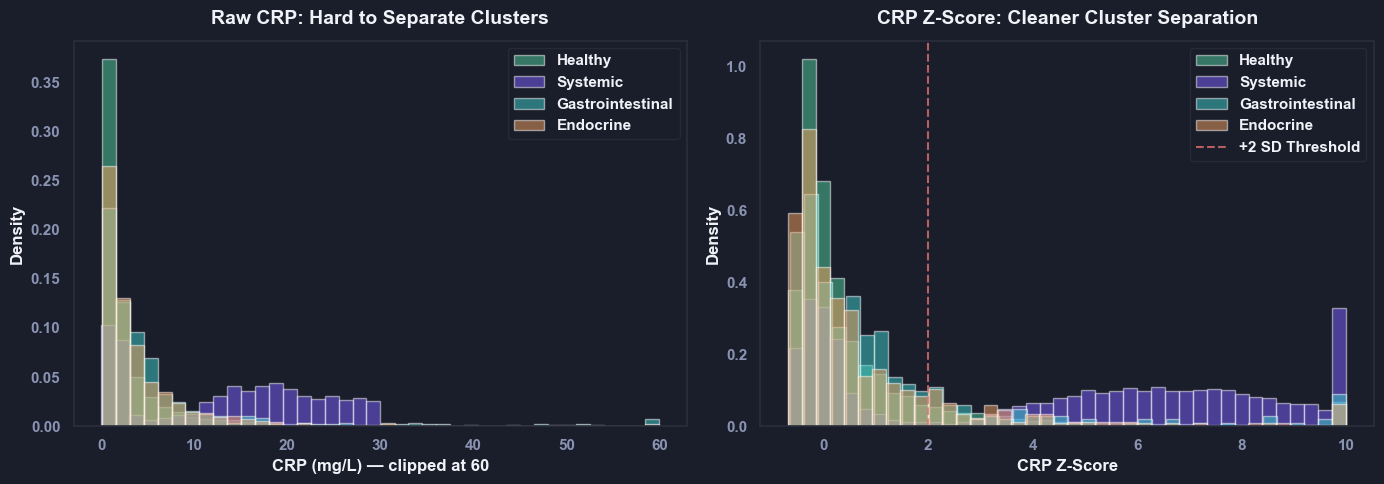

Key insight: Z-scores normalize CRP against the healthy population baseline
Patients with autoimmune disease cluster above +2 SD much more clearly


In [3]:
# Show that the same raw CRP spans healthy and sick patients
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor(C['card'])

# ── Raw CRP — hard to separate ────────────────────────────────────────────────
for cluster, col in zip(priority, cluster_colors):
    subset = df[df['diagnosis_cluster'] == cluster]['crp'].dropna().clip(0, 60)
    axes[0].hist(subset, bins=40, alpha=0.5, density=True,
                 label=clean_label(cluster), color=col)

axes[0].set_xlabel('CRP (mg/L) — clipped at 60', color=C['text'])
axes[0].set_ylabel('Density', color=C['text'])
axes[0].set_title('Raw CRP: Hard to Separate Clusters',
                  color=C['text'], fontweight='bold', fontsize=14, pad=12)
axes[0].legend(facecolor=C['card'], edgecolor=C['border'], labelcolor=C['text'])
axes[0].tick_params(colors=C['muted'])
for spine in axes[0].spines.values():
    spine.set_edgecolor(C['border'])

# ── CRP z-score — cleaner separation ─────────────────────────────────────────
if 'crp_zscore' in df.columns:
    for cluster, col in zip(priority, cluster_colors):
        subset = df[df['diagnosis_cluster'] == cluster]['crp_zscore'].dropna().clip(-3, 10)
        axes[1].hist(subset, bins=40, alpha=0.5, density=True,
                     label=clean_label(cluster), color=col)

    axes[1].axvline(x=2, color=C['error'], linestyle='--', linewidth=1.5,
                    alpha=0.8, label='+2 SD Threshold')
    axes[1].set_xlabel('CRP Z-Score', color=C['text'])
    axes[1].set_ylabel('Density', color=C['text'])
    axes[1].set_title('CRP Z-Score: Cleaner Cluster Separation',
                      color=C['text'], fontweight='bold', fontsize=14, pad=12)
    axes[1].legend(facecolor=C['card'], edgecolor=C['border'], labelcolor=C['text'])
    axes[1].tick_params(colors=C['muted'])
    for spine in axes[1].spines.values():
        spine.set_edgecolor(C['border'])

plt.tight_layout()
plt.savefig('../outputs/figures/02_raw_vs_zscore.png', dpi=150, bbox_inches='tight')
plt.show()

print('Key insight: Z-scores normalize CRP against the healthy population baseline')
print('Patients with autoimmune disease cluster above +2 SD much more clearly')

## 2. Z-Score Normalization

Z-scores are computed per marker against the healthy population in our dataset. This accounts for age and sex-related variation in lab values.

In [4]:
# Show z-score columns already in the data
zscore_cols = [c for c in df.columns if c.endswith('_zscore')]
print(f'Z-score features available: {len(zscore_cols)}')
for c in zscore_cols:
    print(f'  {c}')

print()
print('Z-Score Statistics by Cluster:')
print('-' * 60)

if 'crp_zscore' in df.columns:
    stats = df.groupby('diagnosis_cluster')['crp_zscore'].agg(['mean', 'std', 'median'])
    print('CRP Z-Score:')
    print(stats.round(3))

Z-score features available: 9
  crp_zscore
  wbc_zscore
  rbc_zscore
  hemoglobin_zscore
  hematocrit_zscore
  mcv_zscore
  mch_zscore
  rdw_zscore
  platelet_count_zscore

Z-Score Statistics by Cluster:
------------------------------------------------------------
CRP Z-Score:
                    mean    std  median
diagnosis_cluster                      
endocrine          0.988  3.268   0.129
gastrointestinal   1.351  3.717   0.456
healthy            0.879  3.617   0.023
systemic           4.551  4.038   5.036


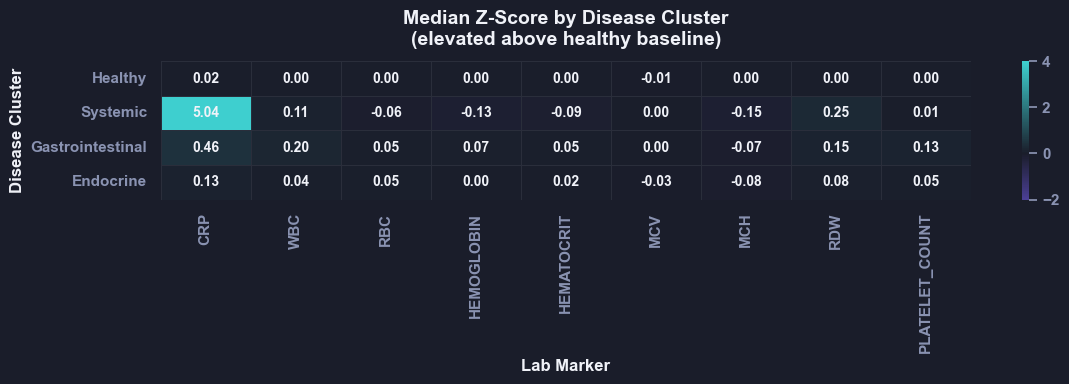

In [5]:
# Z-score heatmap: median z-score per cluster per marker
if len(zscore_cols) >= 2:
    zscore_by_cluster = df.groupby('diagnosis_cluster')[zscore_cols].median()
    zscore_by_cluster = zscore_by_cluster.loc[
        [c for c in priority if c in zscore_by_cluster.index]
    ]

    # Clean row and column labels
    zscore_by_cluster.index = [clean_label(c) for c in zscore_by_cluster.index]
    zscore_by_cluster.columns = [
        c.replace('_zscore', '').upper() for c in zscore_by_cluster.columns
    ]

    fig, ax = plt.subplots(figsize=(12, 4))
    fig.patch.set_facecolor(C['card'])

    sns.heatmap(
        zscore_by_cluster,
        annot=True, fmt='.2f',
        cmap=AURA_DIVERGING, center=0, vmin=-2, vmax=4,
        linewidths=0.5, linecolor=C['border'],
        ax=ax,
        annot_kws={'color': C['text'], 'fontsize': 10, 'fontweight': 'bold'},
    )
    ax.set_title('Median Z-Score by Disease Cluster\n(elevated above healthy baseline)',
                 color=C['text'], fontweight='bold', fontsize=14, pad=12)
    ax.set_xlabel('Lab Marker', color=C['text'])
    ax.set_ylabel('Disease Cluster', color=C['text'])
    ax.tick_params(colors=C['muted'])
    ax.set_facecolor(C['card'])

    plt.tight_layout()
    plt.savefig('../outputs/figures/02_zscore_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

## 3. Engineered Features

Beyond raw values and z-scores, we engineer features that capture clinical patterns:
- **Inflammatory burden**: Combined CRP + ESR z-scores
- **Anemia patterns**: Flag for anemia type (microcytic, normocytic)
- **Autoantibody count**: Number of positive autoantibodies
- **Lab abnormality count**: Total number of out-of-range results

In [6]:
from data.feature_engineering import engineer_all_features

df_engineered = engineer_all_features(df)

# Find new columns
new_cols = [c for c in df_engineered.columns if c not in df.columns]
print(f'Engineered {len(new_cols)} new features:')
for c in sorted(new_cols):
    non_null = df_engineered[c].notna().sum()
    print(f'  {c}: {non_null:,} non-null values')

Engineered 25 new features:
  anemia_flag: 48,503 non-null values
  anemia_severity: 32,142 non-null values
  autoantibody_count: 48,503 non-null values
  c3_c4_ratio: 8,714 non-null values
  calprotectin_elevated: 0 non-null values
  calprotectin_high: 0 non-null values
  complement_consumption: 48,503 non-null values
  crp_esr_ratio: 12,098 non-null values
  high_inflammation: 0 non-null values
  high_nlr: 48,503 non-null values
  high_value_count: 48,503 non-null values
  inflammatory_burden: 48,503 non-null values
  lab_abnormality_count: 48,503 non-null values
  log_calprotectin: 0 non-null values
  low_c3: 48,503 non-null values
  low_c4: 48,503 non-null values
  low_value_count: 48,503 non-null values
  lupus_panel_score: 48,503 non-null values
  lymphocyte_count: 36,406 non-null values
  macrocytic_flag: 48,503 non-null values
  microcytic_flag: 48,503 non-null values
  nlr: 36,418 non-null values
  plr: 36,406 non-null values
  ra_panel_score: 48,503 non-null values
  rdw_elev

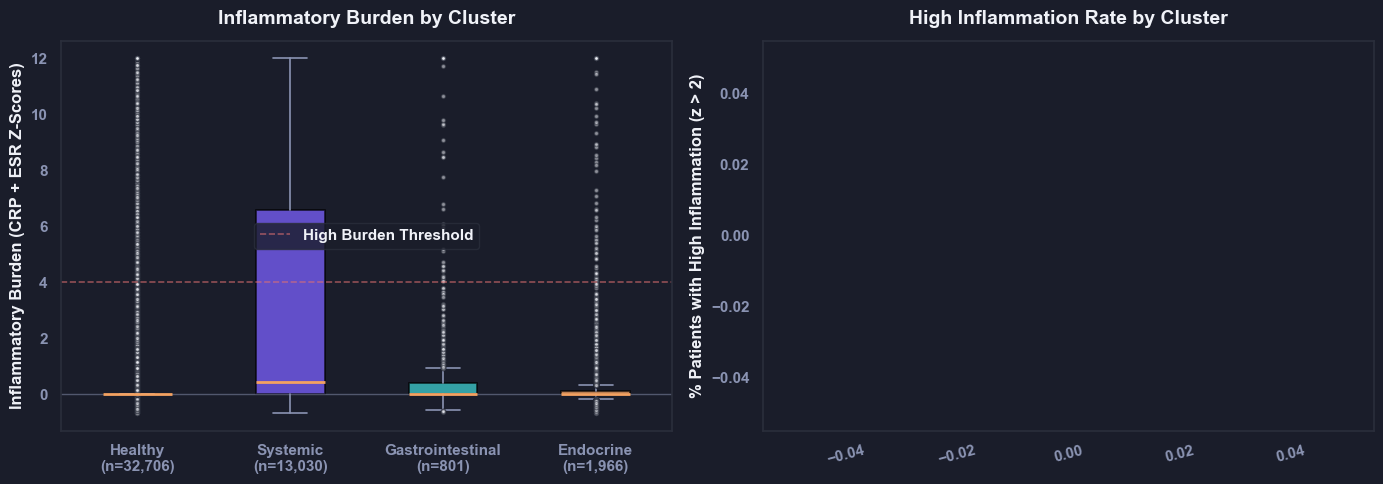

In [7]:
# Visualize inflammatory burden by cluster
if 'inflammatory_burden' in df_engineered.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.patch.set_facecolor(C['card'])

    # ── Left: boxplot with white outlier dots ─────────────────────────────────
    data_to_plot = []
    plot_labels = []
    for cluster in priority:
        subset = df_engineered[df_engineered['diagnosis_cluster'] == cluster]['inflammatory_burden'].dropna()
        if len(subset) > 0:
            data_to_plot.append(subset.clip(-4, 12))
            plot_labels.append(f'{clean_label(cluster)}\n(n={len(subset):,})')

    bp = axes[0].boxplot(data_to_plot, labels=plot_labels, **BOXPLOT_PROPS)
    for patch, col in zip(bp['boxes'], cluster_colors):
        patch.set_facecolor(col)
        patch.set_alpha(0.75)

    axes[0].axhline(y=0, color=C['muted'], linestyle='-', linewidth=1.0, alpha=0.5)
    axes[0].axhline(y=4, color=C['error'], linestyle='--', linewidth=1.2, alpha=0.6,
                    label='High Burden Threshold')
    axes[0].set_ylabel('Inflammatory Burden (CRP + ESR Z-Scores)', color=C['text'])
    axes[0].set_title('Inflammatory Burden by Cluster',
                      color=C['text'], fontweight='bold', fontsize=14, pad=12)
    axes[0].legend(facecolor=C['card'], edgecolor=C['border'], labelcolor=C['text'])
    axes[0].tick_params(colors=C['muted'])
    for spine in axes[0].spines.values():
        spine.set_edgecolor(C['border'])

    # ── Right: high inflammation rate bar chart ───────────────────────────────
    if 'high_inflammation' in df_engineered.columns:
        hi_rate = df_engineered.groupby('diagnosis_cluster')['high_inflammation'].mean() * 100
        hi_rate = hi_rate.reindex(priority).dropna()
        bar_colors = [CATEGORY_COLOR.get(c, C['muted']) for c in hi_rate.index]
        bars = axes[1].bar([clean_label(c) for c in hi_rate.index],
                           hi_rate.values, color=bar_colors)
        axes[1].set_ylabel('% Patients with High Inflammation (z > 2)', color=C['text'])
        axes[1].set_title('High Inflammation Rate by Cluster',
                          color=C['text'], fontweight='bold', fontsize=14, pad=12)
        axes[1].tick_params(axis='x', rotation=15, colors=C['muted'])
        axes[1].tick_params(axis='y', colors=C['muted'])
        for spine in axes[1].spines.values():
            spine.set_edgecolor(C['border'])
        for i, v in enumerate(hi_rate.values):
            axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center', color=C['text'], fontsize=10)

    plt.tight_layout()
    plt.savefig('../outputs/figures/02_inflammatory_burden.png', dpi=150, bbox_inches='tight')
    plt.show()

## 4. Missingness as a Feature

When a doctor orders — or doesn't order — a test, that's clinical information. Missing ESR in a young female with joint pain is different from missing ESR in a healthy 30-year-old male.

In [8]:
from data.preprocessing import prepare_features

# Show the feature groups available
feature_groups = ['demographics', 'cbc', 'inflammatory', 'zscore', 'missing']
X_full, feature_names = prepare_features(df_engineered, feature_groups)

print(f'Total model features: {len(feature_names)}')
print()

# Group features
missing_features = [f for f in feature_names if f.endswith('_missing')]
zscore_features = [f for f in feature_names if f.endswith('_zscore')]
other_features = [f for f in feature_names if not f.endswith('_missing') and not f.endswith('_zscore')]

print(f'Demographics + lab values: {len(other_features)}')
print(f'Z-score features: {len(zscore_features)}')
print(f'Missingness flags: {len(missing_features)}')

# Missingness rate by cluster
if missing_features:
    print(f'\nMissingness flags: {missing_features}')

Total model features: 32

Demographics + lab values: 13
Z-score features: 9
Missingness flags: 10

Missingness flags: ['wbc_missing', 'rbc_missing', 'hemoglobin_missing', 'hematocrit_missing', 'platelet_count_missing', 'mcv_missing', 'mch_missing', 'rdw_missing', 'esr_missing', 'crp_missing']


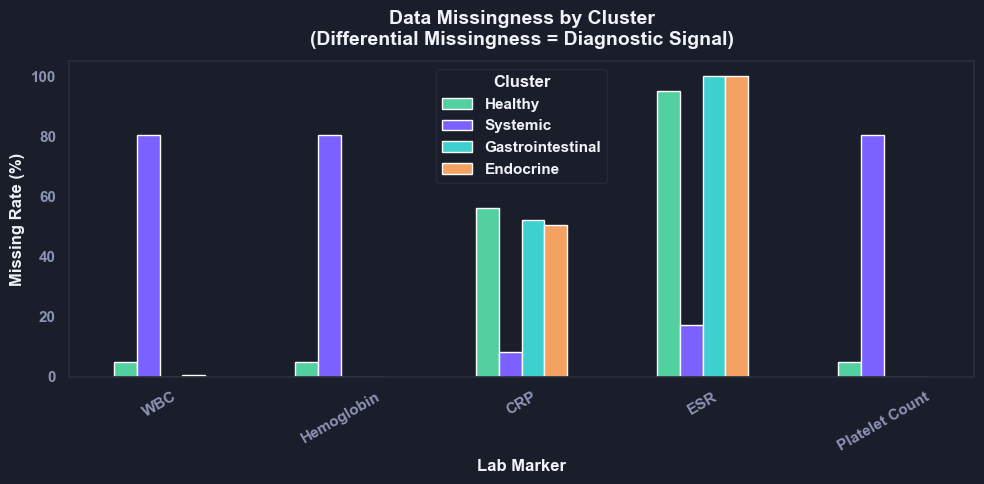

In [9]:
# Show that missingness rate differs by cluster (clinically informative)
raw_markers = ['wbc', 'hemoglobin', 'crp', 'esr', 'platelet_count']
available_markers = [m for m in raw_markers if m in df_engineered.columns]

missingness_by_cluster = pd.DataFrame({
    marker: {
        cluster: df_engineered[df_engineered['diagnosis_cluster'] == cluster][marker].isna().mean() * 100
        for cluster in priority
    }
    for marker in available_markers
}).T

# Clean row labels for display
missingness_by_cluster.index = [clean_label(m) for m in missingness_by_cluster.index]
missingness_by_cluster.columns = [clean_label(c) for c in missingness_by_cluster.columns]

fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor(C['card'])

bar_colors = [CATEGORY_COLOR.get(c, C['muted']) for c in priority]
missingness_by_cluster.plot(kind='bar', ax=ax, color=bar_colors)

ax.set_xlabel('Lab Marker', color=C['text'], fontweight='bold')
ax.set_ylabel('Missing Rate (%)', color=C['text'], fontweight='bold')
ax.set_title('Data Missingness by Cluster\n(Differential Missingness = Diagnostic Signal)',
             color=C['text'], fontweight='bold', fontsize=14, pad=12)
ax.legend(title='Cluster', facecolor=C['card'], edgecolor=C['border'], labelcolor=C['text'],
          title_fontproperties={'weight': 'bold'})
ax.tick_params(axis='x', rotation=30, colors=C['muted'])
ax.tick_params(axis='y', colors=C['muted'])
for spine in ax.spines.values():
    spine.set_edgecolor(C['border'])

plt.tight_layout()
plt.savefig('../outputs/figures/02_missingness_by_cluster.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Feature Correlation Structure

Understanding relationships between features guides model interpretation and prevents misleading attributions.

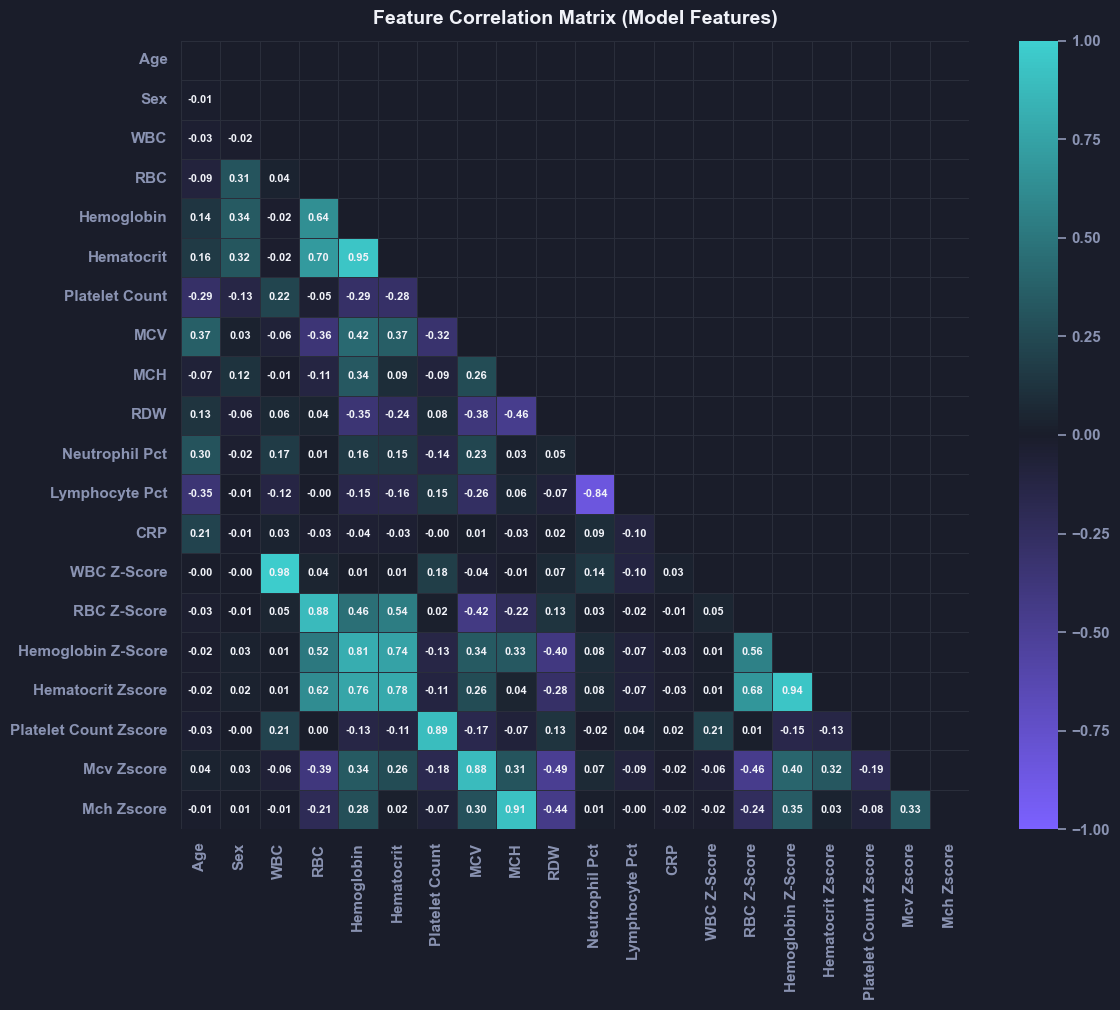

High correlations (|r| > 0.7):
  WBC <-> WBC Z-Score: r=0.982
  Hemoglobin <-> Hematocrit: r=0.945
  Hemoglobin Z-Score <-> Hematocrit Zscore: r=0.943
  MCH <-> Mch Zscore: r=0.914
  Platelet Count <-> Platelet Count Zscore: r=0.891
  MCV <-> Mcv Zscore: r=0.885
  RBC <-> RBC Z-Score: r=0.881
  Neutrophil Pct <-> Lymphocyte Pct: r=-0.841
  Hemoglobin <-> Hemoglobin Z-Score: r=0.811
  Hematocrit <-> Hematocrit Zscore: r=0.785
  Hemoglobin <-> Hematocrit Zscore: r=0.765
  Hematocrit <-> Hemoglobin Z-Score: r=0.743


In [10]:
# Correlation among model features
numeric_feats = [f for f in feature_names if X_full[f].dtype in [np.float64, np.float32, np.int64, np.int32]]
top_feats = numeric_feats[:20]
corr = X_full[top_feats].corr()

# Clean column/index labels for display
corr.columns = [clean_label(c) for c in corr.columns]
corr.index   = [clean_label(c) for c in corr.index]

fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_facecolor(C['card'])

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f',
            cmap=AURA_DIVERGING, center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, linecolor=C['border'],
            ax=ax, annot_kws={'size': 8, 'color': C['text']})

ax.set_title('Feature Correlation Matrix (Model Features)',
             color=C['text'], fontweight='bold', fontsize=14, pad=12)
ax.tick_params(colors=C['muted'])
ax.set_facecolor(C['card'])

plt.tight_layout()
plt.savefig('../outputs/figures/02_feature_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# Highlight high correlations using original names
corr_raw = X_full[top_feats].corr()
corr_pairs = []
for i in range(len(corr_raw.columns)):
    for j in range(i+1, len(corr_raw.columns)):
        val = corr_raw.iloc[i, j]
        if abs(val) > 0.7:
            corr_pairs.append((corr_raw.columns[i], corr_raw.columns[j], val))

if corr_pairs:
    print('High correlations (|r| > 0.7):')
    for f1, f2, r in sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f'  {clean_label(f1)} <-> {clean_label(f2)}: r={r:.3f}')

## 6. Feature Sets for Modeling

We'll use these feature groups in subsequent models, starting minimal and building up.

In [11]:
print('Feature Groups Summary')
print('=' * 60)

group_configs = {
    'Minimal (demographics + CBC)': ['demographics', 'cbc'],
    'Core (+ inflammatory)': ['demographics', 'cbc', 'inflammatory'],
    'Z-score enhanced': ['demographics', 'cbc', 'inflammatory', 'zscore'],
    'Full (+ missingness flags)': ['demographics', 'cbc', 'inflammatory', 'zscore', 'missing'],
}

for name, groups in group_configs.items():
    X_g, feats_g = prepare_features(df_engineered, groups)
    print(f'\n{name}:')
    print(f'  Features: {len(feats_g)}')
    print(f'  Samples with complete data: {X_g.notna().all(axis=1).sum():,}')

print()
print('Next: We test these configurations in 03_baseline_models.ipynb')

Feature Groups Summary

Minimal (demographics + CBC):
  Features: 12
  Samples with complete data: 48,503

Core (+ inflammatory):
  Features: 13
  Samples with complete data: 48,503

Z-score enhanced:
  Features: 22
  Samples with complete data: 48,503

Full (+ missingness flags):
  Features: 32
  Samples with complete data: 48,503

Next: We test these configurations in 03_baseline_models.ipynb


---

## Key Takeaways

1. **Raw lab values overlap substantially** across healthy and autoimmune patients
2. **Z-scores dramatically improve separation** by normalizing for population baseline
3. **Engineered features** (inflammatory burden, anemia flags) capture multi-marker clinical patterns
4. **Missingness flags** encode diagnostic behavior — what wasn't tested is often informative
5. **Feature correlations** inform which features are redundant and which add independent signal

---

*Next: 03_baseline_models.ipynb — Act 3: The Proof (Part 1)*